In [2]:
from patsy import *
# 경고 무시
import warnings
warnings.simplefilter('ignore')

# 자주 사용하는 패키지를 임포트
import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import sklearn as sk
import pgmpy
import scipy.stats

# matplotlib 설정
mpl.use('Agg')

# seaborn 설정
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline

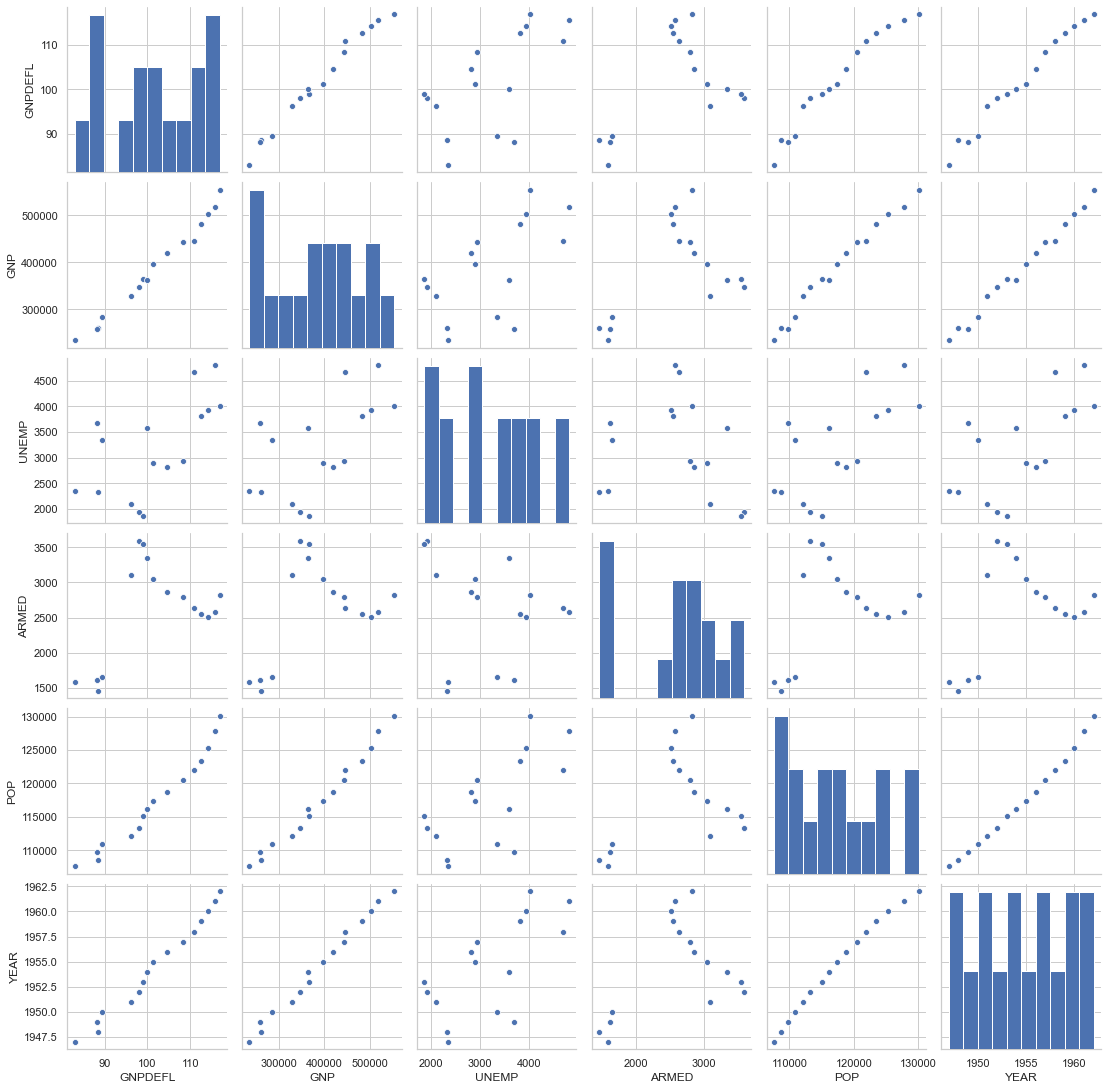

In [3]:
from statsmodels.datasets.longley import load_pandas

dfy = load_pandas().endog
dfX = load_pandas().exog
df = pd.concat([dfy, dfX], axis=1)
sns.pairplot(dfX)
plt.show()

In [4]:
dfX.corr()

,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
GNPDEFL,1.000000,0.991589,0.620633,0.464744,0.979163,0.991149
GNP,0.991589,1.000000,0.604261,0.446437,0.991090,0.995273
UNEMP,0.620633,0.604261,1.000000,-0.177421,0.686552,0.668257
ARMED,0.464744,0.446437,-0.177421,1.000000,0.364416,0.417245
POP,0.979163,0.991090,0.686552,0.364416,1.000000,0.993953
YEAR,0.991149,0.995273,0.668257,0.417245,0.993953,1.000000


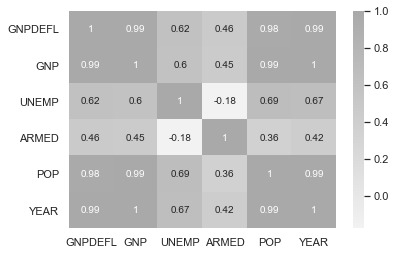

In [5]:
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(dfX.corr(), annot=True, cmap=cmap)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

def get_model1(seed):
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ GNPDEFL + POP + GNP + YEAR + ARMED + UNEMP", data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result1 = get_model1(3)
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     437.5
Date:                Mon, 10 Aug 2020   Prob (F-statistic):             0.0366
Time:                        14:52:09   Log-Likelihood:                -44.199
No. Observations:                   8   AIC:                             102.4
Df Residuals:                       1   BIC:                             103.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.235e+07   2.97e+06     -4.165      0.1

In [7]:
def calc_r2(df_test, result):
    target = df.loc[df_test.index].TOTEMP
    predict_test = result.predict(df_test)
    RSS = ((predict_test - target)**2).sum()
    TSS = ((target - target.mean())**2).sum()
    return 1 - RSS / TSS


test1 = []
for i in range(10):
    df_train, df_test, result = get_model1(i)
    test1.append(calc_r2(df_test, result))

test1

[0.9815050656844267,
 0.973849754306501,
 0.9879366370011322,
 0.7588861967876803,
 0.9807206089304095,
 0.8937889315063796,
 0.8798563810571698,
 0.931466577896602,
 0.8608525682213877,
 0.9677198735128874]

### VIF(다중공선성)

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif

,VIF Factor,features
0,12425.514335,GNPDEFL
1,10290.435437,GNP
2,136.224354,UNEMP
3,39.983386,ARMED
4,101193.161993,POP
5,84709.950443,YEAR


In [9]:
def get_model2(seed):
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ scale(GNP) + scale(ARMED) + scale(UNEMP)", data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result2 = get_model2(3)
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     118.6
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           0.000231
Time:                        14:52:27   Log-Likelihood:                -57.695
No. Observations:                   8   AIC:                             123.4
Df Residuals:                       4   BIC:                             123.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.538e+04    163.988    398.686   

In [11]:
test2 = []
for i in range(10):
    df_train, df_test, result = get_model2(i)
    test2.append(calc_r2(df_test, result))

test2

[0.9763608388904903,
 0.9841984331185691,
 0.9687069366140135,
 0.939730405320177,
 0.9773357061188462,
 0.9561262155732314,
 0.9803852496698645,
 0.9917361722470804,
 0.9837134067639469,
 0.9789512977093211]

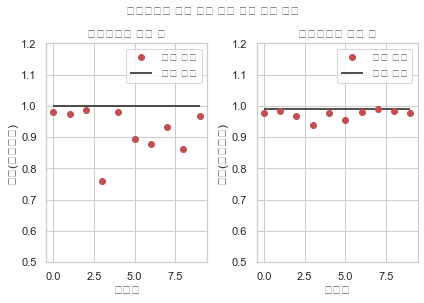

In [12]:
plt.subplot(121)
plt.plot(test1, 'ro', label="검증 성능")
plt.hlines(result1.rsquared, 0, 9, label="학습 성능")
plt.legend()
plt.xlabel("시드값")
plt.ylabel("성능(결정계수)")
plt.title("다중공선성 제거 전")
plt.ylim(0.5, 1.2)

plt.subplot(122)
plt.plot(test2, 'ro', label="검증 성능")
plt.hlines(result2.rsquared, 0, 9, label="학습 성능")
plt.legend()
plt.xlabel("시드값")
plt.ylabel("성능(결정계수)")
plt.title("다중공선성 제거 후")
plt.ylim(0.5, 1.2)

plt.suptitle("다중공선성 제거 전과 제거 후의 성능 비교", y=1.04)
plt.tight_layout()
plt.show()

### 보스턴 집값 예측 문제에 응용

In [13]:
from sklearn.datasets import load_boston
boston = load_boston()

dfX0 = pd.DataFrame(boston.data, columns=boston.feature_names)

from patsy import dmatrix

formula = "scale(CRIM) + scale(I(CRIM ** 2)) + " + \
    "scale(ZN) + scale(I(ZN ** 2)) + scale(INDUS) + " + \
    "scale(NOX) + scale(RM) + scale(AGE) + " + \
    "scale(np.log(DIS)) + scale(RAD) + scale(TAX) + " + \
    "scale(np.log(PTRATIO)) + scale(B) + scale(np.log(LSTAT)) + CHAS"
dfX = dmatrix(formula, dfX0, return_type="dataframe")
dfy = pd.DataFrame(boston.target, columns=["MEDV"])

In [14]:
idx_outlier = \
    np.array([7,  54, 148, 152, 160, 214, 253, 267, 364, 365, 367, 368, 369,
              371, 372, 374, 380, 385, 397, 398, 399, 400, 401, 405, 409, 410,
              412, 413, 414, 415, 416, 418, 419, 426, 445, 489, 490, 492, 505,
              161, 162, 163, 166, 186, 195, 204, 225, 257, 267, 283, 368, 369,
              370, 371, 372])

idx = list(set(range(len(dfX))).difference(idx_outlier))
dfX = dfX.iloc[idx, :].reset_index(drop=True)
dfy = dfy.iloc[idx, :].reset_index(drop=True)

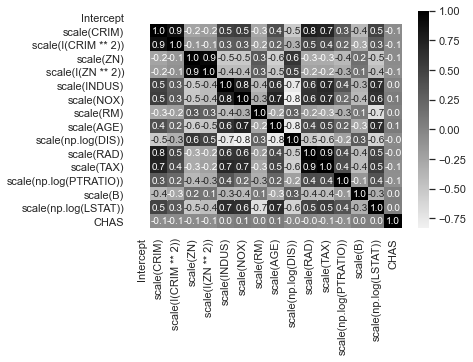

In [15]:
cmap = sns.light_palette("black", as_cmap=True)
sns.heatmap(dfX.corr(), annot=True, fmt='3.1f', cmap=cmap)
plt.show()

In [16]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.061624,CHAS
1,1.338325,scale(B)
2,1.478553,Intercept
3,1.780320,scale(np.log(PTRATIO))
4,2.596496,scale(RM)
5,3.748931,scale(AGE)
6,3.807459,scale(INDUS)
7,4.682812,scale(np.log(LSTAT))
8,5.071802,scale(NOX)
9,5.215025,scale(np.log(DIS))


In [17]:
model_boston1 = sm.OLS(np.log(dfy), dfX)
result_boston1 = model_boston1.fit()
print(result_boston1.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     199.9
Date:                Mon, 10 Aug 2020   Prob (F-statistic):          1.56e-185
Time:                        15:58:01   Log-Likelihood:                 317.45
No. Observations:                 456   AIC:                            -602.9
Df Residuals:                     440   BIC:                            -536.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

In [18]:
cols = ["Intercept", "CHAS", "scale(B)", "scale(CRIM)",
        "scale(np.log(PTRATIO))", "scale(RM)", "scale(np.log(LSTAT))"]

model_boston2 = sm.OLS(np.log(dfy), dfX[cols])
result_boston2 = model_boston2.fit()
print(result_boston2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     380.7
Date:                Mon, 10 Aug 2020   Prob (F-statistic):          1.42e-172
Time:                        15:58:10   Log-Likelihood:                 260.52
No. Observations:                 456   AIC:                            -507.0
Df Residuals:                     449   BIC:                            -478.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3